# Why SVD?

Этот ноутбук нужен чтобы: 
* поэксперементировать, повизуализировать
* показать почему ипользовать SVD - может оказаться хорошей идеей

### Funtions and Imports

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from numpy.linalg import svd
from sklearn.decomposition import PCA  # uses SVD
import cv2 as cv

np.random.seed(21)
random_state = 147

DATA_DIR = "data"
TRAIN_JPG = "data/stage_2_train_images_jpg"

In [2]:
def get_sample(df: pd.DataFrame, n=-1, random_state=147) -> pd.DataFrame:
    """Get sample of df in n rows"""

    if "class" in df.columns:
        df = df.drop(columns="class")  

    if n == -1 or n==26684:
        return df

    df = df.copy()
    df = df.sample(
        n=n, 
        random_state=random_state, 
        ignore_index=True  # the resulting index will be labeled 0, 1, … n-1
    )
  
    return df

In [3]:
img_info = pd.read_csv('data/merged_df_v1.csv').iloc[:, 2:]
img_info.head(4)

,patient_id,class,enc_class
0,f6f837c1-d12b-4b47-862f-76b2402ef616,Normal,2
1,bdace88f-39ec-48e2-93db-0476cdf7e582,Normal,2
2,584f7e37-6bbf-4194-b671-61bcf49c56e5,Lung Opacity,0
3,d3377394-0574-49fa-990e-05121ef7bee7,No Lung Opacity / Not Normal,1


## **Поэксперементируем на одном изображении**

In [4]:
sample = get_sample(img_info, n=1)
sample

,patient_id,enc_class
0,3be0c383-ad5b-422e-a003-5676bc9d66df,2


In [5]:
curr_path = f"{TRAIN_JPG}/{"3be0c383-ad5b-422e-a003-5676bc9d66df"}.jpg"
img = cv.imread(curr_path, cv.IMREAD_GRAYSCALE)

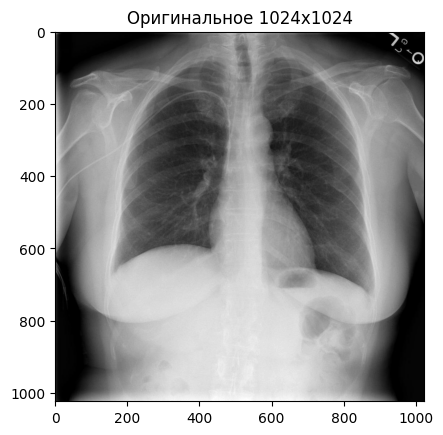

In [6]:
plt.imshow(img, cmap='gray')
plt.title("Оригинальное 1024x1024");

In [7]:
U, Sigma, VT = svd(img, full_matrices=False)

print(U.shape)
print(Sigma.shape)
print(VT.shape)

(1024, 1024)
(1024,)
(1024, 1024)


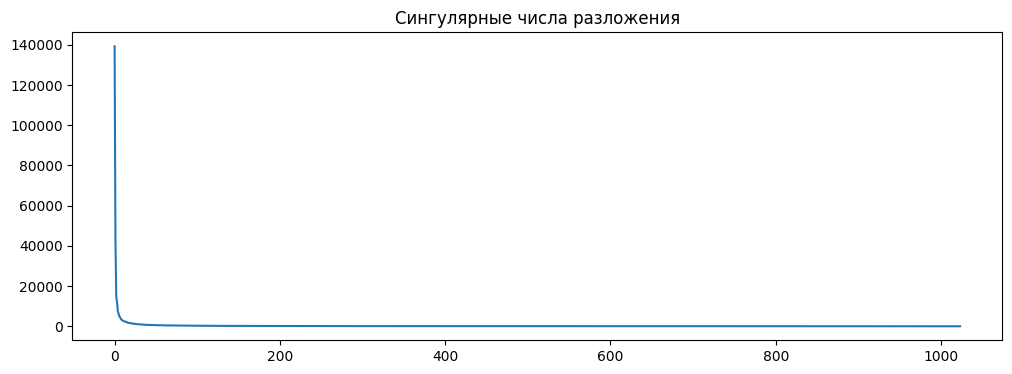

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(Sigma)
plt.title("Сингулярные числа разложения");

* На графике выше значение сингулярных чисел падает очень быстро.

* Чем меньше номер компоненты $\rightarrow$ Тем больше сигма $\rightarrow$ Тем она важнее

* Можно подобрать оптимальный уровень сжатия, чтобы "растерять" лишнюю информацию, и оставить нужную.

In [9]:
def get_comp_r(n1, n2):
    """ 
    Return image in original size, but without info.
    It show amount of left info.

    Will get info from n1 to n2 components.
    """
    
    n1, n2 = n1-1, n2
    dot_dim = n2 - n1

    S_cut = np.diag(Sigma[n1:n2])
    U_cut = U[:, n1:n2].reshape(-1, dot_dim)
    VT_cut = VT[n1:n2, :].reshape(dot_dim, -1)
    return U_cut @ S_cut @ VT_cut

In [ ]:
def plot_components(start=1, end=1024, mode="seq", last=None) -> None:
    """
    Plot 5 graph in a row. On images info from these components.
    
    Args:
        mode (str): "seq" or "start"
        last (str): custom numbers of components. len(last) 5 or 6.
    """
    end -= 1
    fig, ax = plt.subplots(1, 5, figsize=(18, 3))

    if last is not None and len(last) >=5 and len(last) <= 6:
        if len(last) == 5:
            mode == "start"
        else:
            mode == "seq"
    else:
        last = np.linspace(start, end+1, 6).astype("int")
        if mode == "start":
            last = last[1:]

    if mode == "seq":
        for i in range(5):
            ax[i].imshow(get_comp_r(last[i], last[i+1]), cmap='gray')
            ax[i].set_title(f"{last[i]} - {last[i+1]} components")
    elif mode == "start":
        for i in range(5):
            ax[i].imshow(get_comp_r(1, last[i]), cmap='gray')
            ax[i].set_title(f"1 - {last[i]} components")
    else:
        print("unknown mode")


На графиках отображается каковы будут изображения, если взять **только эти** компоненты SVD разложения

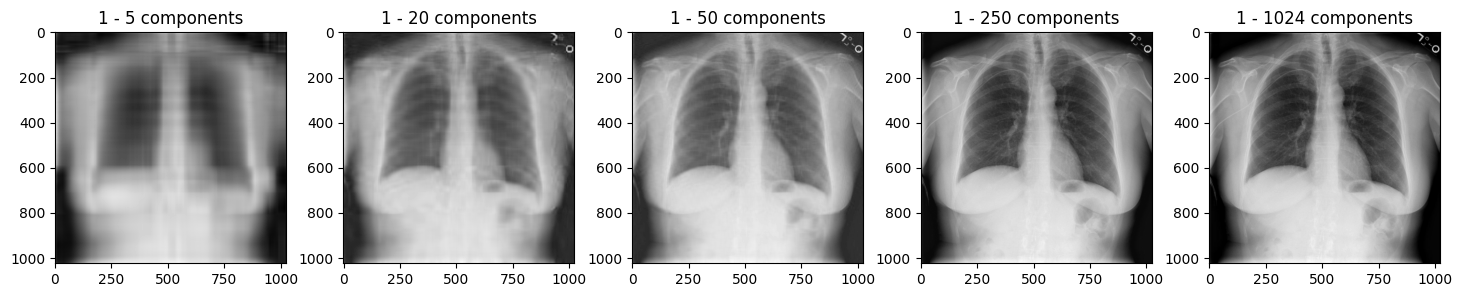

In [11]:
plot_components(mode="start", last=[5, 20, 50, 250, 1024])

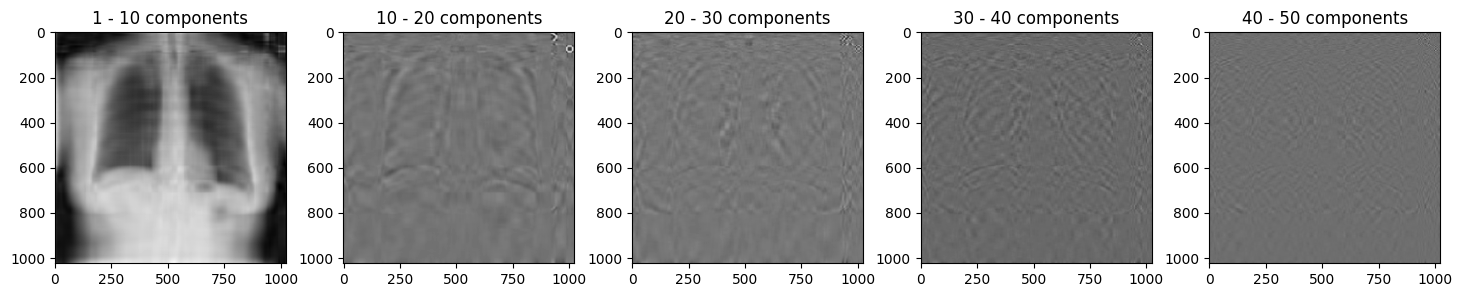

In [12]:
plot_components(end=50, mode="seq")

Уже при использовании только первых пяти компонент получается изоюражение отдалённо напоминающее оригинал.

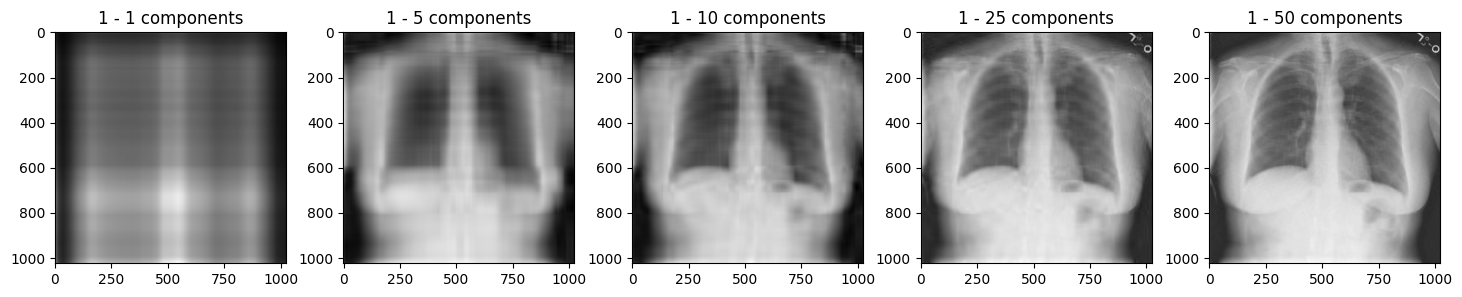

In [13]:
plot_components(mode="start", last=[1, 5, 10, 25, 50])

На графике ниже можно увидеть, что последние компоненты почти не содержат информации. 

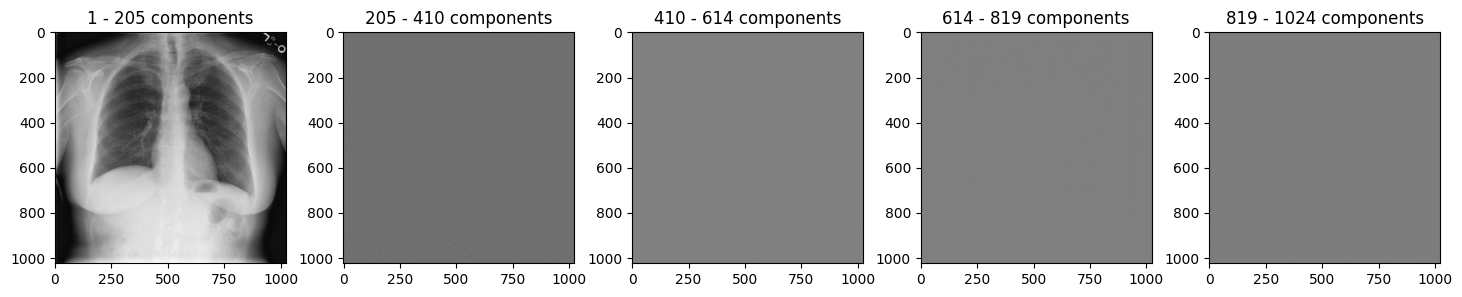

In [14]:
plot_components()

## Посмотрим что проиходит с несколькими изображениями

Возьмём выборку в 50 изображений

Note: Сингулярные числа в разложении будут положительные

In [15]:
sample = get_sample(img_info, n=50)
sample.shape

(50, 2)

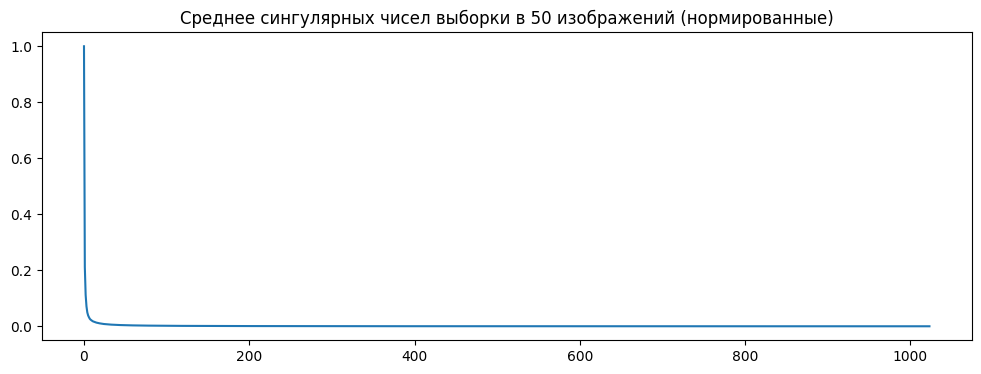

In [16]:
sum_sigmas = np.zeros(1024)  # он "вектором" хранит, там матрица диагональная

for row in sample["patient_id"]:
    curr_path = f"{TRAIN_JPG}/{row}.jpg"
    img = cv.imread(curr_path, cv.IMREAD_GRAYSCALE)
    U, Sigma, VT = svd(img, full_matrices=False)
    Sigma = Sigma / Sigma[0]  # отнормируем на большее сингулярное число (нас доля интересует)
    sum_sigmas += Sigma

sum_sigmas = sum_sigmas / sample.shape[0]  # поделим на число изображений

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Среднее сингулярных чисел выборки в 50 изображений (нормированные)")
sns.lineplot(sum_sigmas);

На выборке из 50-ти изображений заметен тот же эффект. Можно заметить, что отнорированный модуль сингулярного числа очень быстро падает. 

## Центрирование

Дополнительно удостоверимся, что **центрирование данных ничего не испортит**. `sklearn.decomposition.PCA` будет центрировать данные перед применением SVD

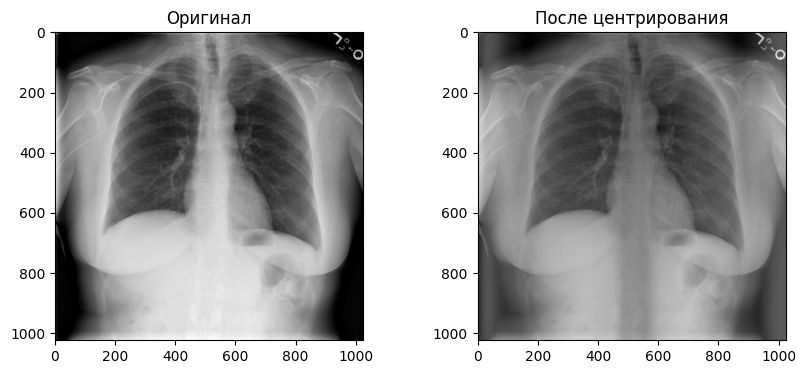

In [17]:
curr_path = f"{TRAIN_JPG}/{"3be0c383-ad5b-422e-a003-5676bc9d66df"}.jpg"
img = cv.imread(curr_path, cv.IMREAD_GRAYSCALE)
img_centered = img - np.mean(img, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].imshow(img, cmap='gray')
ax[0].set_title(f"Оригинал")

ax[1].imshow(img_centered, cmap='gray')
ax[1].set_title(f"После центрирования");

Ничего не сломалось. Даже стало более различимо.

`sklearn.decomposition.PCA` не будет скалировать, поэтому перед использованием модели нужно будет нормировать данные.